In [0]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
import numpy as np
import re
import gensim
from collections import defaultdict

In [0]:
nltk.download('stopwords')

In [0]:
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z]+"
DATASET_ENCODING = "ISO-8859-1"

In [0]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [0]:
df = pd.read_csv('/content/drive/My Drive/sarcastic_comments_train.csv',index_col=0)

In [0]:
abbr={"ain't": "is not", "isn't": 'is not',"cannot": "can not", "aren't": "are not", "can't": "can not", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",
                "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will", "he's": "he is", "how'd": "how did",
                "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am",
                "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have",
                "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", "so's": "so as", "this's": "this is", "that'd": "that would",
                "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is", "they'd": "they would",
                "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not",
                "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
                "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "wont": "will not", "won't've": "will not have", "would've": "would have",
                "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have",
                "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'colour': 'color',
                'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor',
                'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', '2F4U':	'Too Fast For You',
                'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I',
                'theBest': 'the best', 'howdoes': 'how does', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what',
                'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization', 'AKA':	'also known as', 'ACK':	'Acknowledgment', 'AFAIK':	'As far as I know', 'AFAIR':	'As far as I remember'}

abbr = {k.lower(): v.lower() for k, v in abbr.items()}

In [0]:
def normalize_word(word):
    temp = word
    while True:
        w = re.sub(r"([a-zA-Z])\1\1", r"\1\1", temp)
        if (w == temp):
            break
        else:
            temp = w
    return w

In [0]:
def preprocess(text,abbreviation_dict=abbr, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()

    filtered_text=[]
    for t in text.split(' '):
        if (t in abbreviation_dict):
            tok = abbreviation_dict.get(t).split(' ')
            filtered_text.extend(tok)
        else:
            filtered_text.append(t)

    tokee=[normalize_word(word) for word in filtered_text]

    tokens = []
    for token in tokee:
        if stem:
            tokens.append(stemmer.stem(token))
        else:
            tokens.append(token)
    ll=['b','c','d','e','f','g','h','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
    tokens=[g for g in tokens if g not in ll]
    if len(tokens)>=1:
        return " ".join(tokens)
    else:
        return float('NaN')
df.comment = df.comment.apply(lambda x: preprocess(x))

In [0]:
df=df.dropna(axis=0,how='any')

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.comment)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 109443


In [0]:
X = pad_sequences(tokenizer.texts_to_sequences(df.comment), maxlen=400)

In [0]:
y=df.label
y=np.array(y)
y = y.reshape(-1,1)

In [14]:
embeddings_index = dict()
f = open('/content/drive/My Drive/glove.6B.300d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [0]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Activation, BatchNormalization, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, Embedding, LSTM
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow

In [0]:
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=400, trainable=False)

In [18]:
### MODEL-1 ###
model = Sequential()
model.add(e)
model.add(Conv1D(filters=64, kernel_size=3, kernel_initializer='he_normal', activation='sigmoid', padding='valid',input_shape=(1,400)))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, kernel_initializer='he_normal', activation='sigmoid', padding='valid'))
#model.add(MaxPooling1D(pool_size=2))
#model.add(LSTM(128, kernel_initializer='he_normal', activation='sigmoid', dropout=0.25, return_sequences=True))
model.add(LSTM(256, kernel_initializer='he_normal', activation='sigmoid', dropout=0.25))
model.add(Dense(128, kernel_initializer='he_normal', activation='sigmoid'))
model.add(Dense(64, kernel_initializer='he_normal', activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 400, 300)          32832900  
_________________________________________________________________
conv1d (Conv1D)              (None, 398, 64)           57664     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 396, 128)          24704     
_________________________________________________________________
lstm (LSTM)                  (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6

In [0]:
### MODEL-2 ###
model = Sequential()
model.add(e)
model.add(Conv1D(filters=64, kernel_size=3, kernel_initializer='he_normal', activation='sigmoid', padding='valid',input_shape=(1,400)))
#model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, kernel_initializer='he_normal', activation='sigmoid', padding='valid'))
#model.add(MaxPooling1D(pool_size=2))
#model.add(Bidirectional(LSTM(128, kernel_initializer='he_normal', activation='sigmoid', dropout=0.25, return_sequences=True)))
model.add(Bidirectional(LSTM(256, kernel_initializer='he_normal', activation='sigmoid',dropout=0.25)))
model.add(Dense(128, kernel_initializer='he_normal', activation='sigmoid'))
model.add(Dense(64, kernel_initializer='he_normal', activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [0]:
# PLOT MODEL
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1)

In [21]:
history = model.fit(X,y, batch_size=1024, epochs=20, validation_split=0.1,verbose=1, callbacks=[es])

Epoch 1/20
405/405 [==============================] - 309s 764ms/step - loss: 0.6785 - accuracy: 0.5617 - val_loss: 0.6515 - val_accuracy: 0.6188
Epoch 2/20
405/405 [==============================] - 307s 759ms/step - loss: 0.6408 - accuracy: 0.6313 - val_loss: 0.6364 - val_accuracy: 0.6309
Epoch 3/20
405/405 [==============================] - 304s 751ms/step - loss: 0.6248 - accuracy: 0.6469 - val_loss: 0.6218 - val_accuracy: 0.6489
Epoch 4/20
405/405 [==============================] - 306s 757ms/step - loss: 0.6120 - accuracy: 0.6593 - val_loss: 0.6018 - val_accuracy: 0.6691
Epoch 5/20
405/405 [==============================] - 310s 765ms/step - loss: 0.5965 - accuracy: 0.6748 - val_loss: 0.5846 - val_accuracy: 0.6855
Epoch 6/20
405/405 [==============================] - 312s 771ms/step - loss: 0.5826 - accuracy: 0.6879 - val_loss: 0.5756 - val_accuracy: 0.6944
Epoch 7/20
405/405 [==============================] - 313s 773ms/step - loss: 0.5735 - accuracy: 0.6962 - val_loss: 0.5687 -

In [0]:
model.save('/content/drive/My Drive/CNNLSTM_train.h5') 

In [23]:
model = tf.keras.models.load_model('/content/drive/My Drive/CNNLSTM_train.h5')

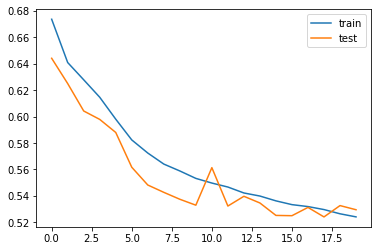

In [0]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
df1 = pd.read_csv('/content/drive/My Drive/sarcastic_comments_test.csv',index_col=0)

In [0]:
df1.comment = df1.comment.apply(lambda x: preprocess(x))

In [0]:
df1=df1.dropna(axis=0,how='any')

In [0]:
X1 = pad_sequences(tokenizer.texts_to_sequences(df1.comment), maxlen=400)

In [0]:
y1=df1.label
y1=np.array(y1)
y1 = y1.reshape(-1,1)

In [39]:
model.evaluate(X1,y1)


3599/3599 [==============================] - 150s 42ms/step - loss: 0.5398 - accuracy: 0.7232


[0.5398172736167908, 0.7231910228729248]

In [0]:
import tensorflow
new_input = model.input
hidden_layer = model.layers[-2].output

features_extract_model = tensorflow.keras.Model(new_input, hidden_layer)
features_extract_model.trainable=False

In [41]:
tf.executing_eagerly()

True

In [0]:
I=[i for i in range(0,X.shape[0],1000)]

In [0]:
I.append(X.shape[0])

In [0]:
NDF=pd.DataFrame(columns=[str(t) for t in range(64)])
for i in range(len(I[0:-1])):
    x=tf.convert_to_tensor(X[I[i]:I[i+1]])
    z=features_extract_model(x)
    ndf=pd.DataFrame(z.numpy(),columns=[str(t) for t in range(64)])
    lst = [NDF, ndf]
    NDF = pd.concat(lst)

In [47]:
NDF

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,0.231430,0.352931,0.232025,0.606499,0.549468,0.539599,0.437592,0.323234,0.650981,0.648691,0.451481,0.189666,0.413894,0.752051,0.509668,0.407237,0.140910,0.742027,0.146832,0.448269,0.674707,0.301753,0.550699,0.249950,0.300689,0.349405,0.169064,0.111726,0.271988,0.544923,0.466076,0.263267,0.262848,0.316530,0.602520,0.531608,0.201113,0.188011,0.145850,0.385094,0.314296,0.444696,0.223954,0.743735,0.830242,0.281772,0.815895,0.393487,0.628838,0.428363,0.690105,0.456538,0.272487,0.639819,0.184266,0.514249,0.430497,0.682713,0.538324,0.620999,0.415200,0.153995,0.469210,0.563165
1,0.285400,0.280855,0.309056,0.690448,0.629205,0.632035,0.509149,0.413318,0.733105,0.725586,0.530865,0.135359,0.337519,0.804715,0.590082,0.506966,0.101012,0.801865,0.170794,0.509009,0.592571,0.354594,0.651956,0.311090,0.382311,0.289675,0.230790,0.163489,0.359548,0.443361,0.522579,0.201728,0.195044,0.232233,0.496986,0.455459,0.144521,0.122659,0.181734,0.312899,0.240488,0.518400,0.173341,0.667426,0.883685,0.357278,0.871824,0.330535,0.716373,0.517706,0.740414,0.377812,0.336039,0.558734,0.131916,0.600984,0.344973,0.778269,0.605696,0.681855,0.339217,0.105349,0.391168,0.490527
2,0.259602,0.315595,0.275291,0.652674,0.591544,0.589445,0.474199,0.372337,0.698281,0.690780,0.489585,0.160169,0.371900,0.779884,0.554924,0.462727,0.120253,0.773628,0.158722,0.478898,0.625067,0.329089,0.608256,0.281386,0.342607,0.316674,0.204076,0.138289,0.321293,0.490418,0.493556,0.227510,0.225033,0.268570,0.541100,0.490187,0.171045,0.150243,0.167259,0.346213,0.272983,0.482918,0.193889,0.701710,0.859236,0.321756,0.847256,0.359304,0.677596,0.478099,0.716047,0.414957,0.306571,0.593226,0.157291,0.565091,0.381068,0.737766,0.574830,0.658285,0.374811,0.127841,0.427011,0.523648
3,0.135609,0.568508,0.123433,0.385045,0.354287,0.333921,0.264728,0.171629,0.417465,0.410441,0.270935,0.395903,0.621124,0.558305,0.316164,0.228673,0.341952,0.526354,0.086212,0.267503,0.811338,0.174238,0.331260,0.139753,0.160514,0.546920,0.085860,0.043297,0.139913,0.746310,0.304265,0.470444,0.488822,0.540826,0.781340,0.705282,0.419118,0.421010,0.082157,0.583726,0.536257,0.261738,0.414428,0.858338,0.595354,0.146342,0.589362,0.553585,0.400259,0.254974,0.508863,0.652017,0.143387,0.786650,0.402635,0.325770,0.625559,0.418562,0.351140,0.449257,0.610430,0.376007,0.665616,0.731804
4,0.256028,0.319747,0.262084,0.642367,0.581280,0.578273,0.467271,0.359131,0.688087,0.682831,0.485078,0.165043,0.381432,0.775816,0.548619,0.450037,0.121396,0.771875,0.157717,0.475822,0.635517,0.324885,0.597387,0.272469,0.334392,0.323226,0.193437,0.131853,0.308530,0.504324,0.491608,0.232600,0.232021,0.275320,0.556638,0.496099,0.174881,0.157857,0.160451,0.351499,0.282653,0.477444,0.199256,0.713251,0.855982,0.311365,0.842654,0.362880,0.670880,0.466050,0.713529,0.418632,0.299761,0.605897,0.159954,0.552626,0.390857,0.725773,0.571346,0.649042,0.383497,0.131711,0.437430,0.526776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587,0.216491,0.381766,0.210946,0.573881,0.520956,0.505727,0.414888,0.288955,0.616031,0.616030,0.417708,0.213789,0.442223,0.733526,0.485206,0.374849,0.157154,0.723365,0.143045,0.427868,0.693611,0.282220,0.520477,0.227889,0.276235,0.375570,0.149515,0.096336,0.248454,0.587121,0.456744,0.283188,0.290044,0.342084,0.635390,0.549405,0.224218,0.215862,0.132644,0.413182,0.344245,0.417941,0.245704,0.766766,0.807249,0.255782,0.790324,0.405397,0.599961,0.396832,0.672797,0.481298,0.254121,0.665085,0.207059,0.482732,0.463733,0.642630,0.520454,0.597138,0.440166,0.183721,0.500046,0.583028
588,0.158653,0.504709,0.144445,0.441195,0.400698,0.385048,0.309333,0.202360,0.477538,0.

In [48]:
df

,label,comment
198526,0,well they aren that similar so there isn reall...
484469,0,their are universities in canada as well though
266858,0,welcome to japan where the game devs wear lab ...
126334,1,nah then people would have to actually get on ...
131105,1,bizarre he still performing when he already le...
...,...,...
465015,1,hah do not come here and tell fables of a long...
28675,1,another ominous sign that global warming is re...
528212,1,should i explain end tags or should you look t...
43258,1,because it means you would have settled for le...


In [0]:
NDF.to_csv('/content/drive/My Drive/sarcastic_comments_train_extracted.csv')

In [0]:
df.label.to_csv('/content/drive/My Drive/sarcastic_comments_train_labels.csv')